# SpatialCorr Tutorial

#### In this tutorial we will demonstrate some of the methods available in the SpatialCorr Python package for identifying and visualizing spatially varying correlation in spatial transcriptomics data. 

SpatialCorr offers a number of statistical tests for testing for spatially varying correlation:
1. **Within-Region (WR)** test that tests for varying correlation _within_ each histological region 
    * **Test across the slide.** The null hypothesis holds that for _all_ regions, the correlation is static within each region. A low p-value thus indicates that there exists a region with putative spatially varying correlation.
    * **Test within a specific region.** For a given region, the null hypothesis is that the correlation is static within the region. A low p-value indicates spatially varying correlation across the region.
        
2. **Between-Region (BR)** test that tests for varying correlation _between_ each histological region
    * **Test across the slide.** The null hypothesis holds that _all_ regions share the same correlation structure. A low p-value thus indicates that there exists a region with putatively different correlation from another region.
    * **Test between two specific regions.** For a given pair of regions, the null hypothesis is that the correlation is the same between these two regions. A low p-value indicates that the correlation differs.

### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import sys
from anndata import AnnData
import scanpy as sc
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append('../../spatialcorr')

import spatialcorr

warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

SpatialCorr comes prepackaged with example datasets to get a user started. These datasets are stored as AnnData objects following the paradigm of the Scanpy library. Thus, SpatialCorr analyses can be integrated into existing Scanpy or Squidy analyses.

The dataset that we will use in this tutorial is a cartaneous squamous cell carcinoma sample from [ji et al. (2020)](https://doi.org/10.1016/j.cell.2020.05.039). It has been pre-normalized using the [Dino algorithm](https://doi.org/10.1093/bioinformatics/btab450).

In [2]:
adata = spatialcorr.load_dataset('GSM4284326_P10_ST_rep2')

### Plot clusters

SpatialCorr controls for difference in expression between distinct histological regions of the slide and thus, it is important to include clustered or annotated information. Here, we'll plot some cluster assignments that were pre-computed for this dataset using the BayesSpace method.

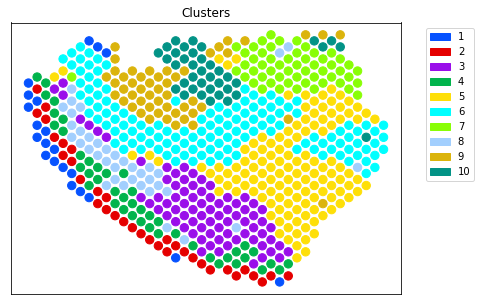

In [3]:
spatialcorr.plot.plot_slide(
    adata.obs, 
    adata.obs['cluster'], 
    cmap='categorical', 
    colorbar=True,
    title="Clusters",
    ticks=False,
    dsize=70
)

### Specify a set of genes to analyze

Let's specify a set of genes that we will analyze. These genes are highly expressed genes in this dataset that belong to the GO Term for Keratinocyte Differentiation.

In [4]:
KERATINOCYTE_DIFF_GENES = [
    'KRT1',
    'KRT10',
    'KRT14',
    'KRT16',
    'KRT17',
    'KRT5',
    'KRT6A',
    'KRT6B',
    'KRT6C'
]

# High-level wrapper functions for analyzing and visualizing spatial correlation 

##### In the following section, we demonstrate SpatialCorr's high-level functions for visualizing and analyzing spatially varying correlation structure. These functions are "wrapper" functions around more detailed 

### Diagnose SpatialCorr's spatial kernel

SpatialCorr's statistical analyses pool nearby spots to estimate each spots correlation. Spots are weighted according to a Gaussian kernel. SpatialCorr provides a wrapper function for creating diagnostic figures for examining SpatialCorr's kernel in order to inform the bandwidth parameter.

Kept 476/621 spots.


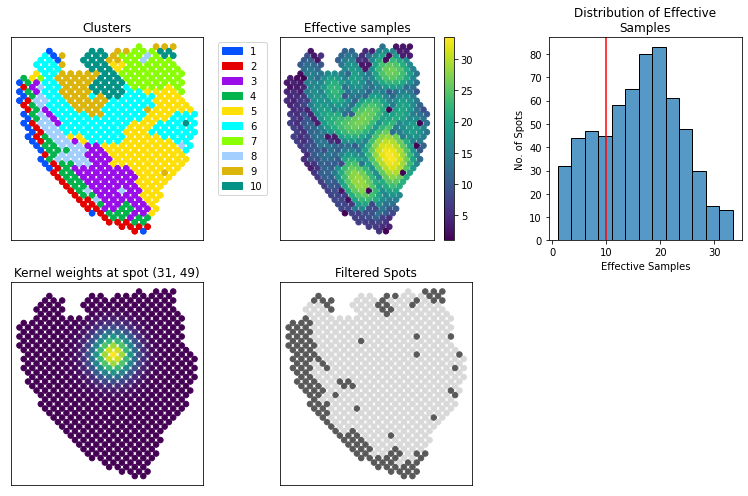

In [5]:
spatialcorr.wrappers.kernel_diagnostics(
    adata,
    'cluster',
    bandwidth=5,
    contrib_thresh=10,
    dsize=30,
    fpath='kernel_diagnostic.png',
    fformat='png',
    dpi=150
)

As you can see, using a larger kernel leads to fewer spots being filtered; however, the granularity of SpatialCorr's correlation estimate will be lower.

Kept 569/621 spots.


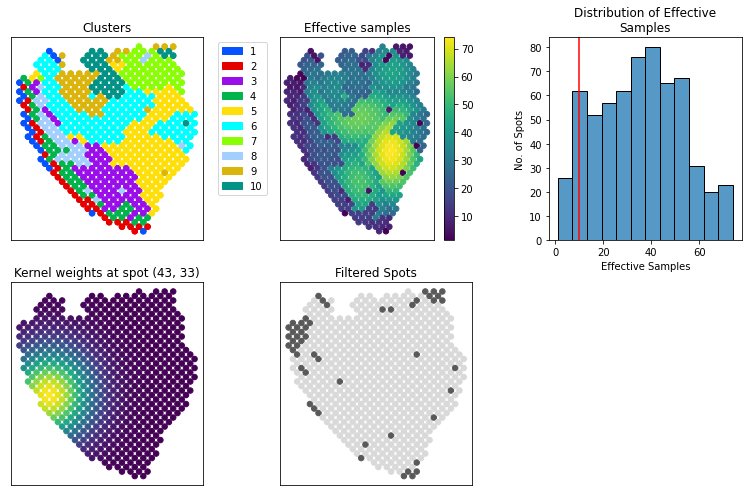

In [6]:
spatialcorr.wrappers.kernel_diagnostics(
    adata,
    'cluster',
    bandwidth=10,
    contrib_thresh=10,
    dsize=30,
    fpath='kernel_diagnostic.png',
    fformat='png',
    dpi=150
)

### Run a SpatialCorr analysis on this full set of genes

Let's say we want to further examine a single pair of genes and test only their spatially varying correlation. SpatialCorr provides a wrapper function that will run the following analysis:
1. For each cluster, compute a WR P-value
2. Remove all clusters with WR P-value < 0.05 for BR-test and for remaining clusters, compute BR P-value testing for differential correlation between the two clusters 

The analysis results in an four-panel figure. In the first column, we plot the cluster assignemnts (top) and spots that were filtered (bottom). Filtered spots are depicted in grey. In the second column we plot the cluster-specific WR P-values (top) and results of testing for differential correlation between all pairs of clusters that do not have within-cluster varying correlation (bottom). A black cell in the matrix denotes a BR p-value < 0.05 between the row and column's cluster.

Kept 476/621 spots.


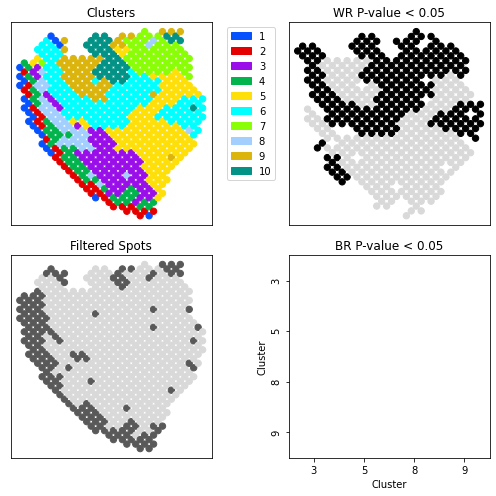

In [7]:
spatialcorr.analysis_pipeline_set(
    KERATINOCYTE_DIFF_GENES,  # The gene set
    adata,                    # The dataset
    'cluster',                # The key in `adata.obs` storing the cluster info
    max_perms=100,            # Maximum number of permutations to run
    dsize=40,                 # Control the size of the dots
    verbose=0                 # Don't output any debugging information
)

### Plot pairwise kernel estimates of correlation

We can use SpatialCorr to plot the pairwise correlation between each pair of genes in a gene spot at each spot on the slide using a kernel estimate.

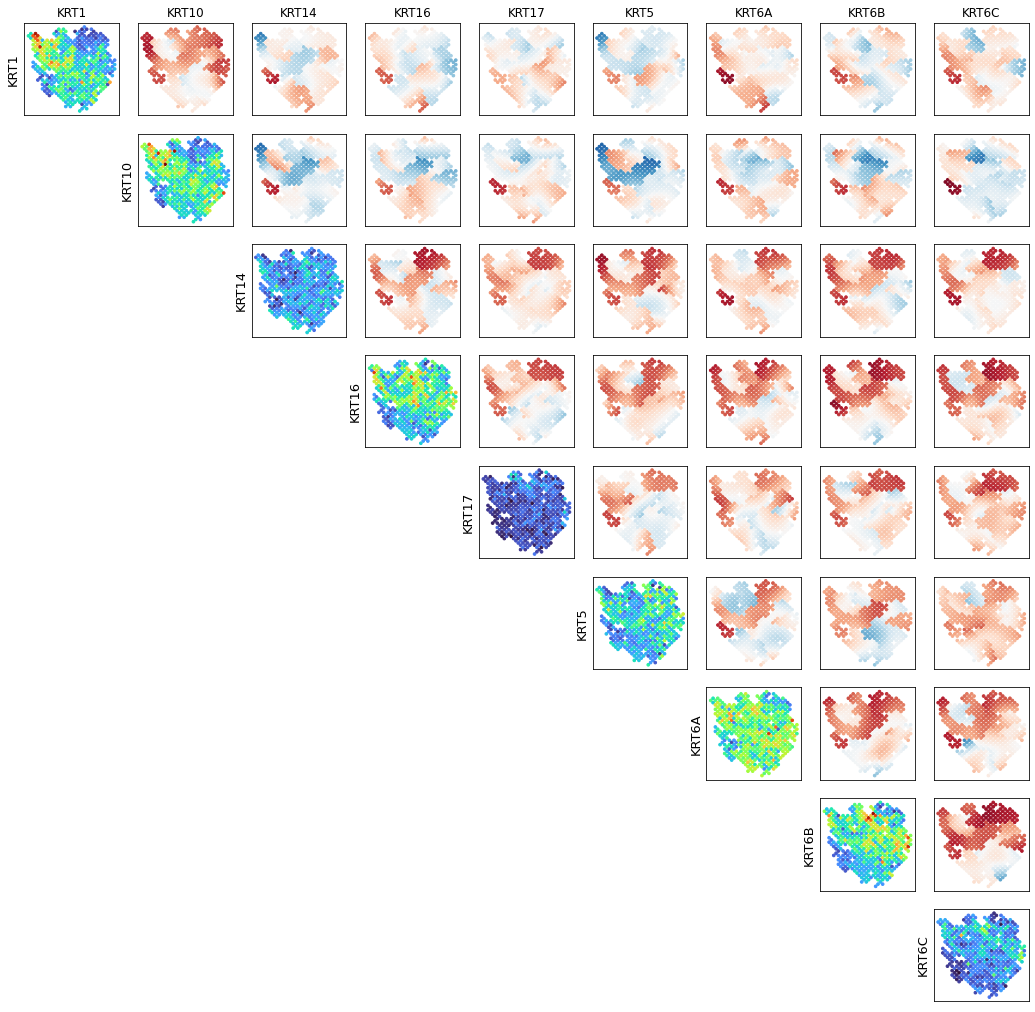

In [8]:
spatialcorr.plot.mult_genes_plot_correlation(
    KERATINOCYTE_DIFF_GENES,
    adata,
    'cluster',
    estimate_type='local'
)

### Cluster the pairwise correlation patterns

We can use SpatialCorr to cluster the pairwise correlation patterns plotted above.

If we plot a few of these subclusters we can see distinct patterns of correlation. Below, we see that keratin pairs that are indicative of basal undifferentiated or proliferative keratinocytes (e.g., KRT14, KRT5, KRT16, KRT6B) show similar pairwise correlations. Vice versa, keratin pairs that tend to be expressed in keratinocytes of differing levels of maturity (differentiated versus undifferentiated) tend to also cluster together and show negative correlation. 

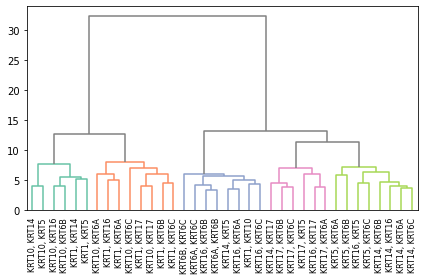

In [9]:
spatialcorr.plot.cluster_pairwise_correlations(
    KERATINOCYTE_DIFF_GENES,
    adata,
    'cluster',
    color_thresh=10
)

### Plot spots where the 95% confidence interval of correlation does not intersect zero

For every pair of genes, for every spot, we compute a local 95% confidence interval (CI) around the estimated correlation. We color a spot red if the CI does not overlap zero and the correlation is positive. We color a spot blue if the CI does not overlap zero and the correlation is negative.

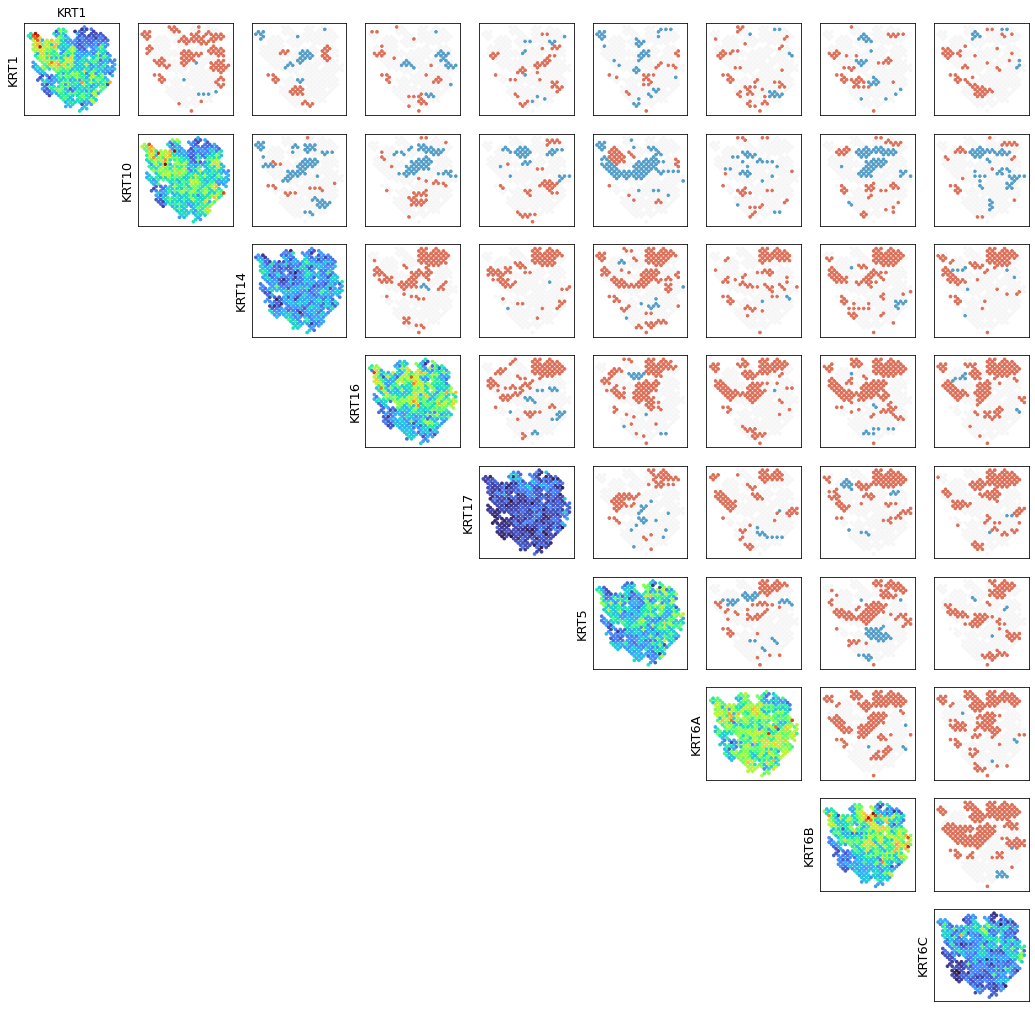

In [10]:
spatialcorr.plot.mult_genes_plot_correlation(
    KERATINOCYTE_DIFF_GENES,
    adata,
    'cluster',
    estimate_type='local_ci'
)

### Plot region-wide estimates of correlation

Instead of using a kernel estimate of the correlation to estimate each spot, we can also plot the cluster-wise correlation computed using each spot within each cluster.


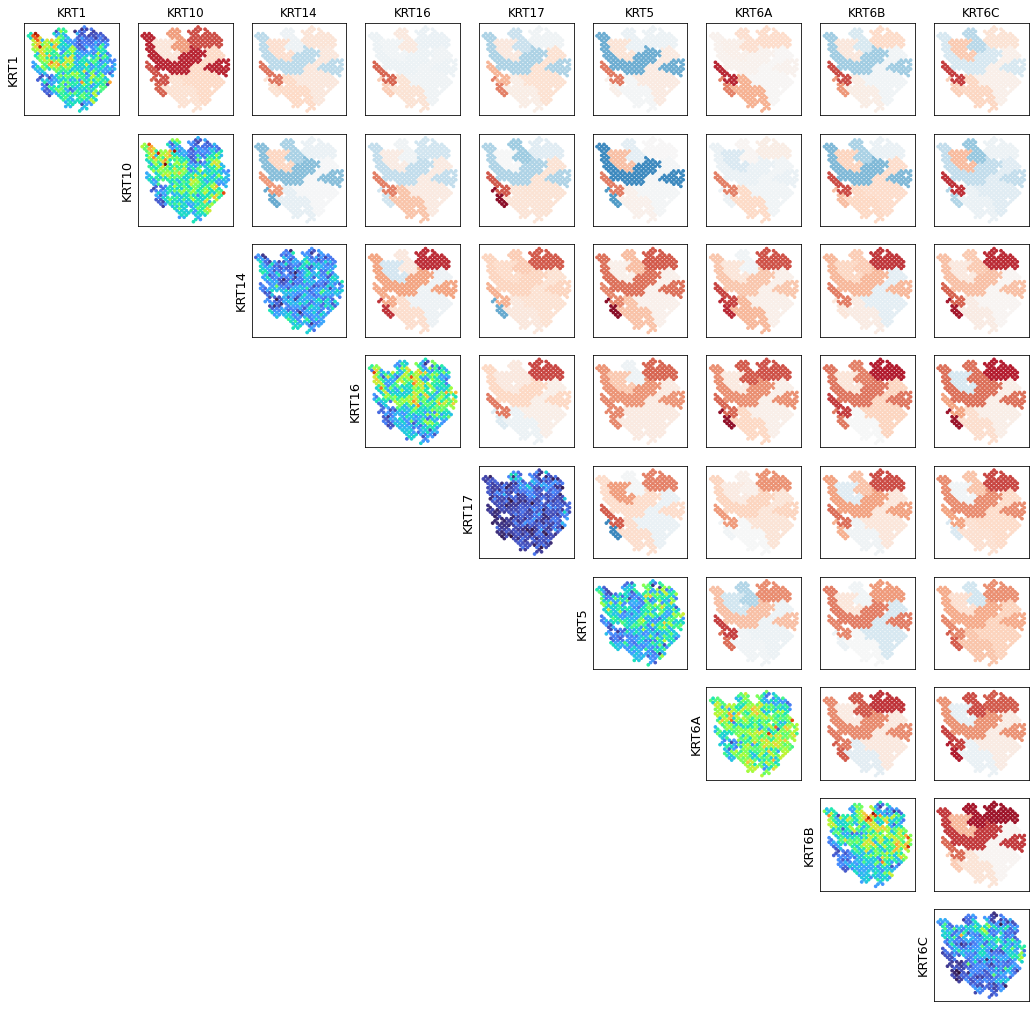

In [12]:
spatialcorr.plot.mult_genes_plot_correlation(
    KERATINOCYTE_DIFF_GENES,   # The set of genes
    adata,                     # The dataset
    'cluster',                 # The key in `adata.obs` storing the cluster info
    estimate_type='regional'   # Set to 'regional' to show cluster-wide estimates
)

### Run a SpatialCorr statistical analysis on a pair of genes

Let's say we want to further examine a single pair of genes and test only their spatially varying correlation. SpatialCorr provides a wrapper function that will run the following analysis:
1. Compute spotwise kernel estimates of correlation
2. Compute confidence intervals (CIs) of correlation at each spot compute spots where CI does not overlap zero (i.e. putative regions with non-zero correlation)
3. For each cluster, compute a WR P-value
4. Remove all clusters with WR P-value < 0.05 for BR test and for remaining clusters, compute BR P-value testing for differential correlation between the two clusters 

The analysis results in an eight-panel figure. In the first column, we plot the expression of both genes. In the second column, we plot the cluster assignemnts (top) and spots that were filtered (bottom). Filtered spots are depicted in grey. In the third column we plo the kernel estimates of the corelation (top) and the cluster-specific WR P-values (bottom). In the top of the fourth column, we plot spots for which the 95 CI does not overlap zero and the correlation at the spot is positive (red) or negative (blue). In the bottom of the fourth column, we display results of testing for differential correlation between all pairs of clusters that do not have within-cluster varying correlation. A black cell in the matrix denotes a BR p-value < 0.05 between the row and column's cluster.

Kept 476/621 spots.


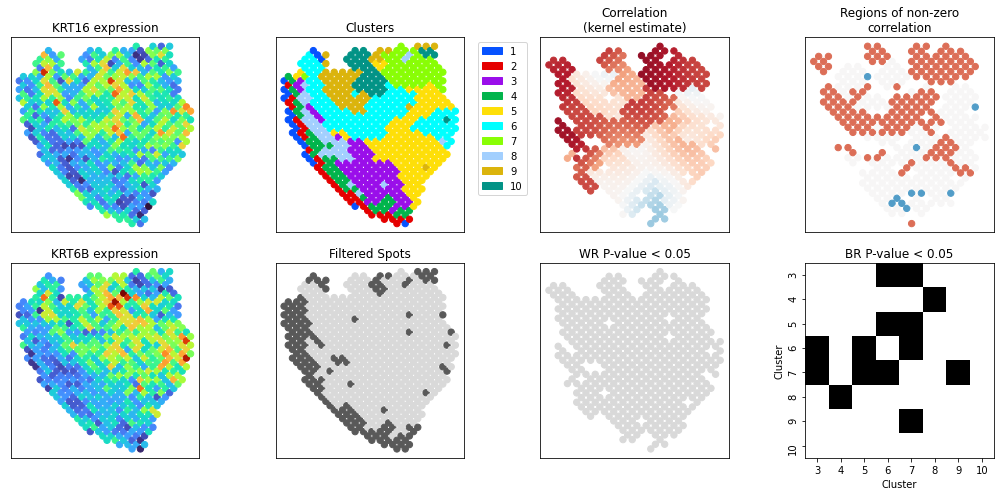

In [13]:
spatialcorr.analysis_pipeline_pair(
    'KRT16',            # Gene 1
    'KRT6B',            # Gene 2
    adata,              # The dataset
    bandwidth=5,        # Kernel bandwidth
    cond_key='cluster', # The key in `adata.obs` storing the cluster info
    max_perms=100,      # Maximum number of permutations to run
    dsize=40,           # Control the size of the dots
    verbose=0,          # Don't output any debuggin information
    fig_path='KRT16_KRT6B_analysis.png', # Output file
    fig_format='png'       # Output format
)

### Plot a scatterplot for each region between a pair of genes

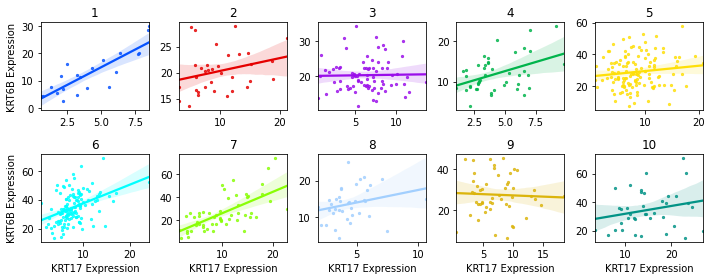

In [14]:
spatialcorr.plot.cluster_pairwise_scatterplots(
    'KRT17',
    'KRT6B',
    adata,
    'cluster',
    bandwidth=5,
    row_key='row',
    col_key='col'
)

## Lower-level functions for performing customized analyses

### Let's run the WR-test on a set of genes

Note, we're going to set the `compute_gene_pair_pvals` argument to True. The test will then run the test on every pair of genes within the gene set using a smaller number of permutations. This will enable us to see which gene pairs are generally contributing to the overall p-value on the entire gene set.

In [5]:
p_val, additional = spatialcorr.run_test(
    adata,                        # The dataset
    KERATINOCYTE_DIFF_GENES,      # The target gene set
    5,                            # The kernel bandwidth
    cond_key='cluster',           # The key in `adata.obs` storing the cluster info
    run_br=False,                 # If True, run BR-test. Otherwise, run WR-test
    contrib_thresh=10,            # Sets the effective sample threshold
    row_key='row',                # The key in `adata.obs` storing the row (i.e. y-coordinate)
    col_key='col',                # The key in `adata.obs` storing the column (i.e. x-coordinate)
    verbose=1,                    # Set the verbosity level. The higher, the more verbose
    n_procs=1,                    # Number of processes to use
    max_perms=100,                # Maximum number of permutations to run. Note, in practice, we'd choose a larger value.
    mc_pvals=True,                # Use sequential Monte Carlo p-values
    compute_gene_pair_pvals=True, # Run the test on each pair of genes in addition to the entire gene set
    gene_pair_perms=100           # Number of permutations to use for each pair of genes
)
clust_to_p_val = additional['region_to_p_val']
clust_to_adj_p_val = additional['region_to_adj_p_val']

print(f"Overall WR p-value: {p_val}")
print(f"Cluster-specific WR p-values: {clust_to_p_val}")
print(f"Cluster-specific WR adj. p-values: {clust_to_adj_p_val}")

Kept 476/621 spots.
Hit maximum permutations threshold of 20. P-value = 0.01
Running test on genes:  KRT10, KRT1
Kept 476/621 spots.
Running test on genes:  KRT14, KRT1
Kept 476/621 spots.
Running test on genes:  KRT14, KRT10
Kept 476/621 spots.
Running test on genes:  KRT16, KRT1
Kept 476/621 spots.
Running test on genes:  KRT16, KRT10
Kept 476/621 spots.
Running test on genes:  KRT16, KRT14
Kept 476/621 spots.
Running test on genes:  KRT17, KRT1
Kept 476/621 spots.
Running test on genes:  KRT17, KRT10
Kept 476/621 spots.
Running test on genes:  KRT17, KRT14
Kept 476/621 spots.
Running test on genes:  KRT17, KRT16
Kept 476/621 spots.
Running test on genes:  KRT5, KRT1
Kept 476/621 spots.
Running test on genes:  KRT5, KRT10
Kept 476/621 spots.
Running test on genes:  KRT5, KRT14
Kept 476/621 spots.
Running test on genes:  KRT5, KRT16
Kept 476/621 spots.
Running test on genes:  KRT5, KRT17
Kept 476/621 spots.
Running test on genes:  KRT6A, KRT1
Kept 476/621 spots.
Running test on genes:

We can access the results of each individual test through the `pairwise_results` key of the `additional` object. For example, here's how to access the p-value and adjusted p-value of the KRT10/KRT1 pair. Note, the adjusted p-value is adjusted over all gene-pair tests:

In [6]:
p_val = additional['pairwise_results']['KRT10']['KRT1']['p_val']
adj_p_val = additional['pairwise_results']['KRT10']['KRT1']['adj_p_val']

print("P-value: ", p_val)
print("Adj. P-value: ", adj_p_val)

P-value:  0.01
Adj. P-value:  0.060000000000000005


Finally, we can use a utility function to grab the most-significant gene-pairs from these results as follows. The function `most_significant_pairs` will return a dataframe with the pairs of genes ranked by their p-value. The dataframe also includes their adjusted p-value

In [7]:
df_top_pairs = spatialcorr.utils.most_significant_pairs(additional)
df_top_pairs

,P-value,Adj. P-value
Genes,,
"KRT1,KRT6B",0.01,0.060000
"KRT6A,KRT6B",0.01,0.060000
"KRT10,KRT6B",0.01,0.060000
"KRT10,KRT6A",0.01,0.060000
"KRT1,KRT10",0.01,0.060000
"KRT10,KRT5",0.01,0.060000
"KRT1,KRT17",0.02,0.102857
"KRT17,KRT5",0.03,0.110769
"KRT10,KRT6C",0.03,0.110769


### Let's run the BR-test on a set of genes

The BR test assumes that correlation is constant within each cluster/region. Thus, we must filter out clusters that have internally varying spatial correlation. We can use SpatialCorr's utility function to create a copy of our dataset that is restricted to only clusters that for which the null was NOT rejected by the WR-test performed above.

In [10]:
# Compute which clusters to keep for BHR test
keep_clusts = [clust for clust, pval in clust_to_p_val.items()]

# Restrict data to these clusters
adata_keep = spatialcorr.utils.select_regions(
    adata,          
    keep_clusts, 
    'cluster'
)
adata_keep

View of AnnData object with n_obs × n_vars = 566 × 16642
    obs: 'row', 'col', 'cluster'

Now we can run the BR-test on this restricted dataset

In [11]:
p_val, additional = spatialcorr.run_test(
    adata_keep,                    # The restricted dataset
    KERATINOCYTE_DIFF_GENES,       # The target gene set
    5,                             # The kernel bandwidth
    cond_key='cluster',            # The key in `adata.obs` storing the cluster info
    run_br=True,                   # If True, run BHR test. Otherwise, run WHR test
    contrib_thresh=10,             # Sets the effective sample threshold
    row_key='row',                 # The key in `adata.obs` storing the row (i.e. y-coordinate)
    col_key='col',                 # The key in `adata.obs` storing the column (i.e. x-coordinate)
    verbose=1,                     # Set the verbosity level. The higher, the more verbose
    n_procs=1,                     # Number of processes to use
    max_perms=100,                 # Maximum number of permutations to run.
    mc_pvals=True,                 # Use sequential Monte Carlo p-values
    compute_gene_pair_pvals=False  # Tell SpatialCorr _NOT_ to run the test on each individual pair of genes
)

print(f"BR p-value: {p_val}")

Kept 476/566 spots.
BR p-value: 0.01
